In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.signal as sg
from scipy.fftpack import fft, ifft
import os, sys
import grad_descent as descender

%matplotlib inline
#matplotlib.rcParams.update({'text.color': 'white'})

In [2]:
def getDataArray(f_path):
    df = pd.read_csv(f_path, sep='\t', names=['Time', 'O2', 'CO2', 'thrw', 'away'],
                 usecols=['Time', 'O2', 'CO2'], index_col=False)
    return df[["Time","O2","CO2"]]

def fourier_trans(t_step, data):
    N = len(data)
    freq_dom = np.linspace(0,1/(2*t_step),N//2)
    power_spectra = fft(data)
    plottable_spectra = (2/N * np.abs(power_spectra))[:N//2]
    return (freq_dom,power_spectra,plottable_spectra)

def filter(f_low, f_high, freq_dom, power_spectra):
    cp = np.copy(power_spectra)
    for i,f in enumerate(freq_dom):
        if (f >= f_low and f<= 50):
            cp[i] = (f_high-f)*(.1/f_high)
            cp[-i] = (f_high-f)*(.1/f_high)
    return np.copy(cp)
            


In [3]:
def showMe(*plots):
    plt.figure(figsize=(20,10))
    for p in plots:
        plt.plot(p)
    plt.show()

def plotFourier(freq_dom, plottable):
    plt.figure(figsize=(20,10))
    plt.semilogx(x = freq_dom, y = plottable)


#load data
#separate time oxy carb resp
#fourier oxy carb resp
#get range of filter from resp
#filter oxy carb
#resample oxy carb
#save to text

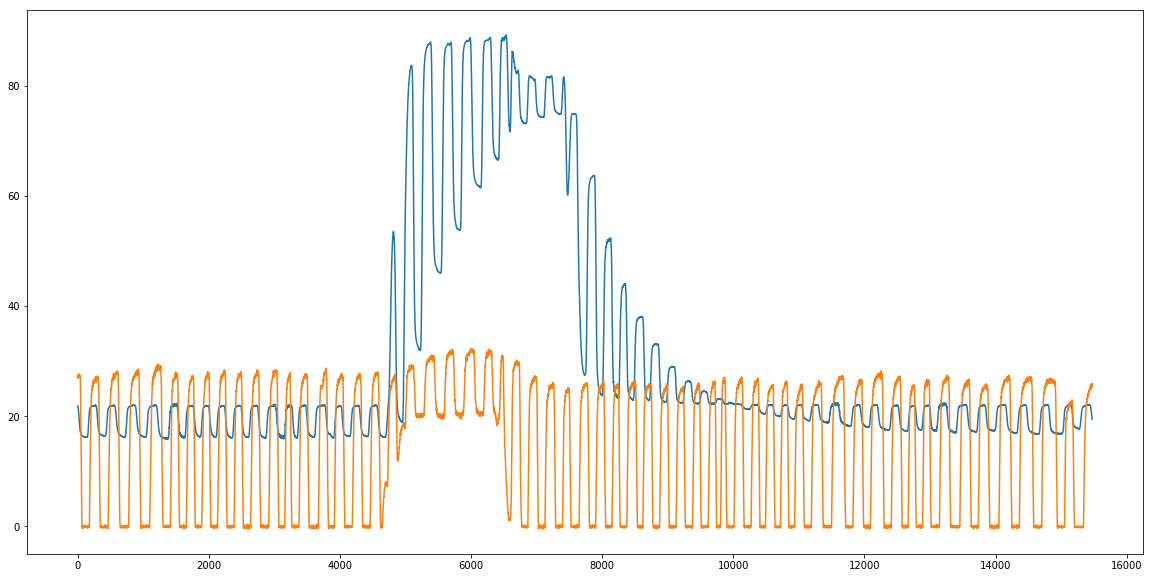

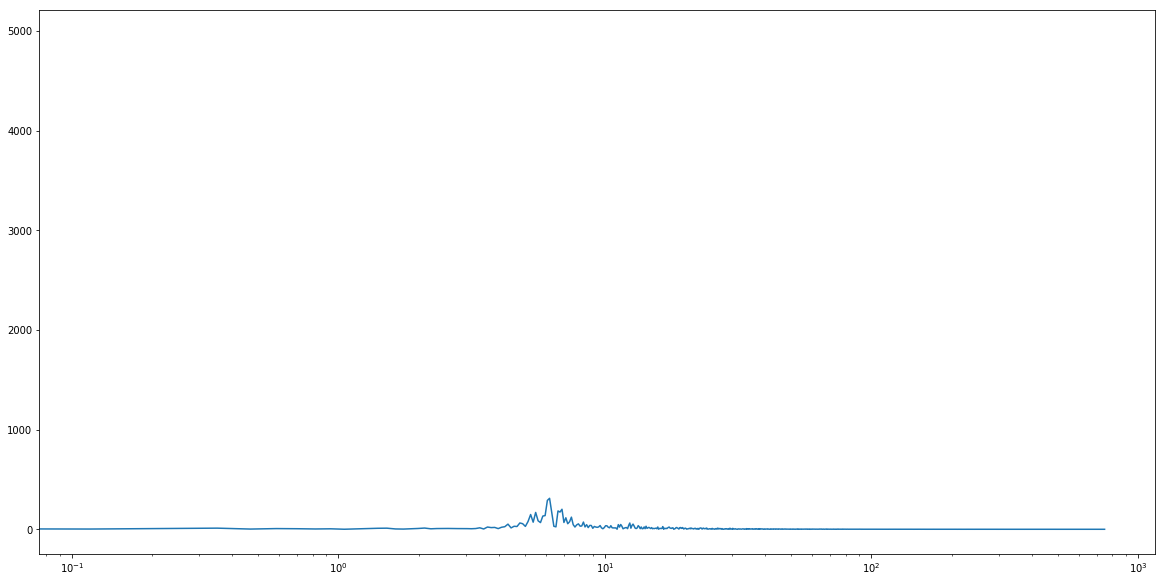

In [4]:
#Load data
        # workstation
#         dataPath = "../../HMRI/Data/Austin_endtidal/BOLD_O2_only_edit.txt"
#         gatePath = "../../HMRI/Data/austin_gating/RESPData_epi_0717201915_49_05_300"

        #home
dataPath = './Data/BOLD_CO2_O2_edit.txt' 
gatePath = './Data/RESPData_epi_0717201916_34_12_484'

#get data
gasses = getDataArray(dataPath)
respiration = pd.read_csv(gatePath, header=None)

#get timing
time = gasses.Time

#separate data into indiv timeseries
oData = gasses.O2
cData = gasses.CO2
respiration = respiration[0]

showMe(oData, cData)

#set up time_steps
t_step_Data = time[1]
t_step_Resp = .04/60

#perform fourier transforms
freqO, powerO, dispO = fourier_trans(t_step_Data, oData)
freqC, powerC, dispC = fourier_trans(t_step_Data, cData)
freqR, powerR, dispR = fourier_trans(t_step_Resp, respiration)

plt.figure(figsize=(20,10))
plt.semilogx(freqR,dispR)




7736


<function matplotlib.pyplot.show(*args, **kw)>

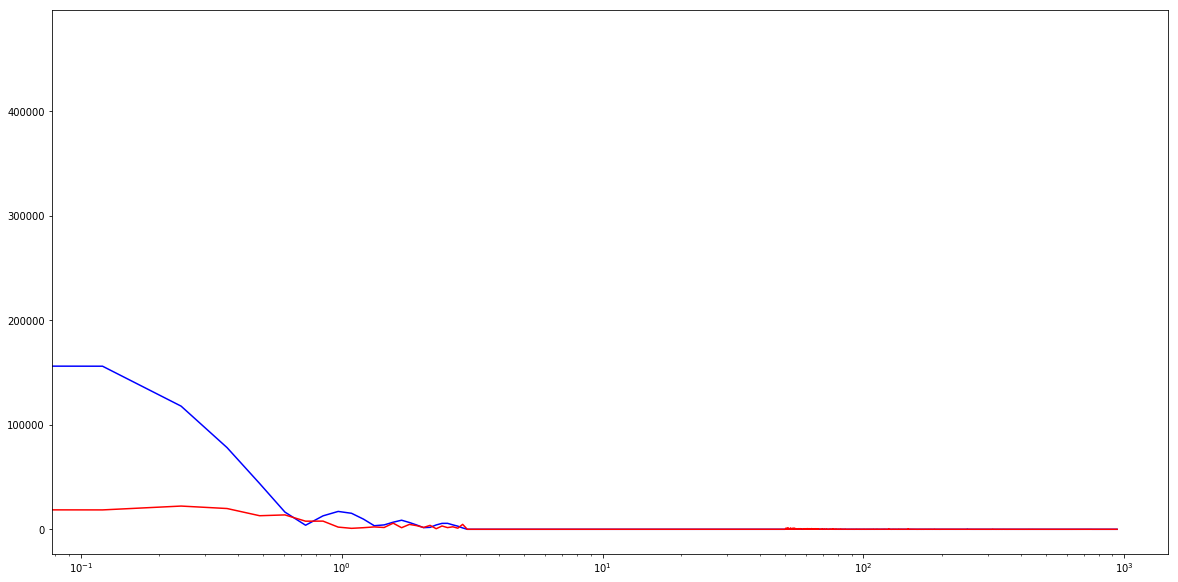

In [53]:
#estimate filter to be from 4 -> 30?
filteredO = filter(3,30,freqO,powerO)
filteredC = filter(3,30,freqC,powerC)

print(len(filteredO[0:len(freqO)]))


plt.figure(figsize=(20,10))
plt.semilogx(freqO, np.abs(filteredO[0:len(freqO)]), '-b')
plt.semilogx(freqO, np.abs(filteredC[0:len(freqO)]), '-r')
plt.show


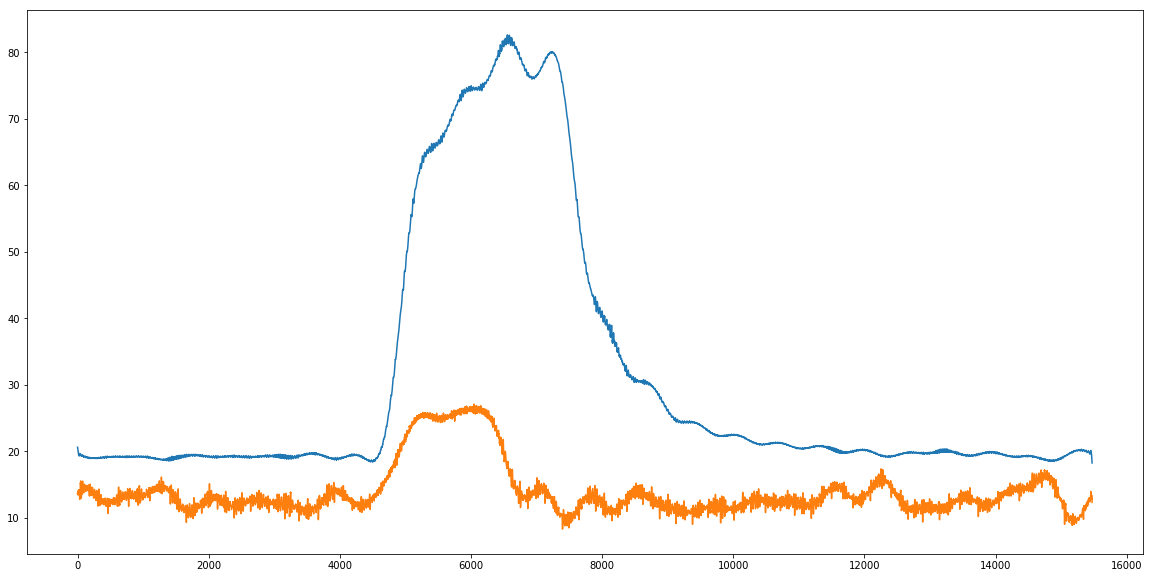

In [54]:
#invert transform
invertedO = ifft(filteredO)
invertedC = ifft(filteredC)

showMe(invertedO, invertedC)

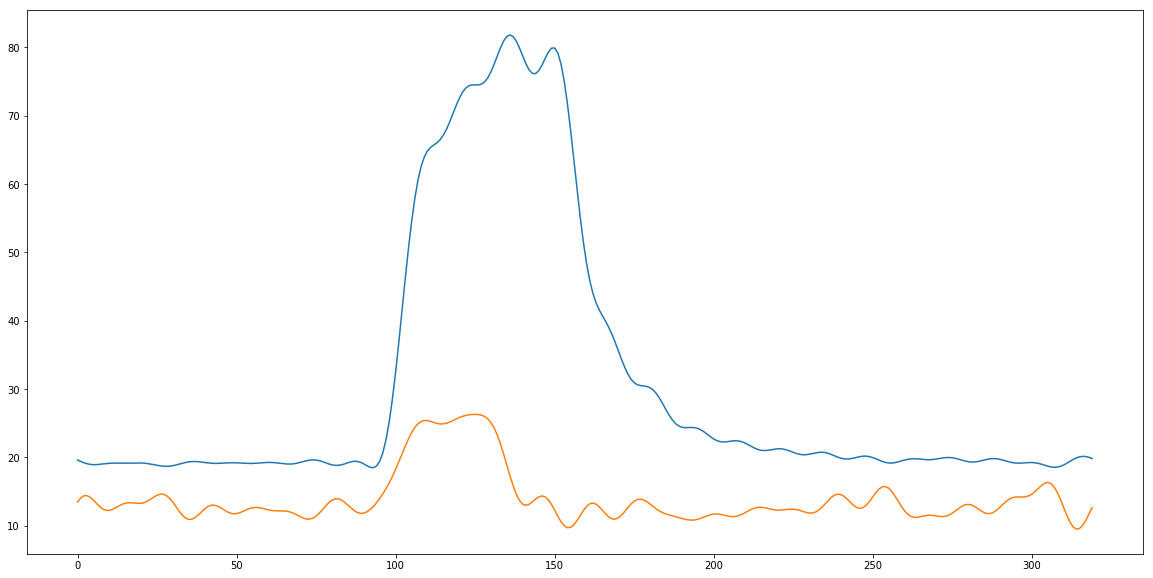

In [55]:
#downsample inverse
downO = sg.resample(invertedO, 320)
downC = sg.resample(invertedC, 320)

showMe(downO, downC)

In [56]:
processed_data_path = './contrasts/'
if(not os.path.exists(processed_data_path)):
    os.mkdir(processed_data_path)
    print ('path created')

np.savetxt(processed_data_path+"contrast_O2.txt",downO.real, fmt = '%.18f', delimiter='\n')
np.savetxt(processed_data_path+"contrast_CO2.txt", downC.real, fmt = '%.18f', delimiter='\n')


# The following performs a crude splitter algorithm to separate our piecewise definition

7301


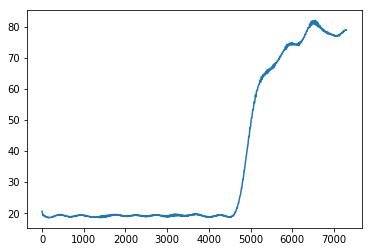

In [15]:
#separate O2
O2_splitter = descender.gd.piece_splitter(invertedO)
print(O2_splitter)
plt.plot(invertedO[:O2_splitter])

In [23]:
z = invertedO.real
A_1 = ((1/z+z)+np.sqrt((z+1/z)**2 -4))/4
A_2 = ((1/z+z)+np.sqrt((z+1/z)**2 -4))/4

print(min(A_1))
print(min(A_2))

9.133768633333283
9.133768633333283


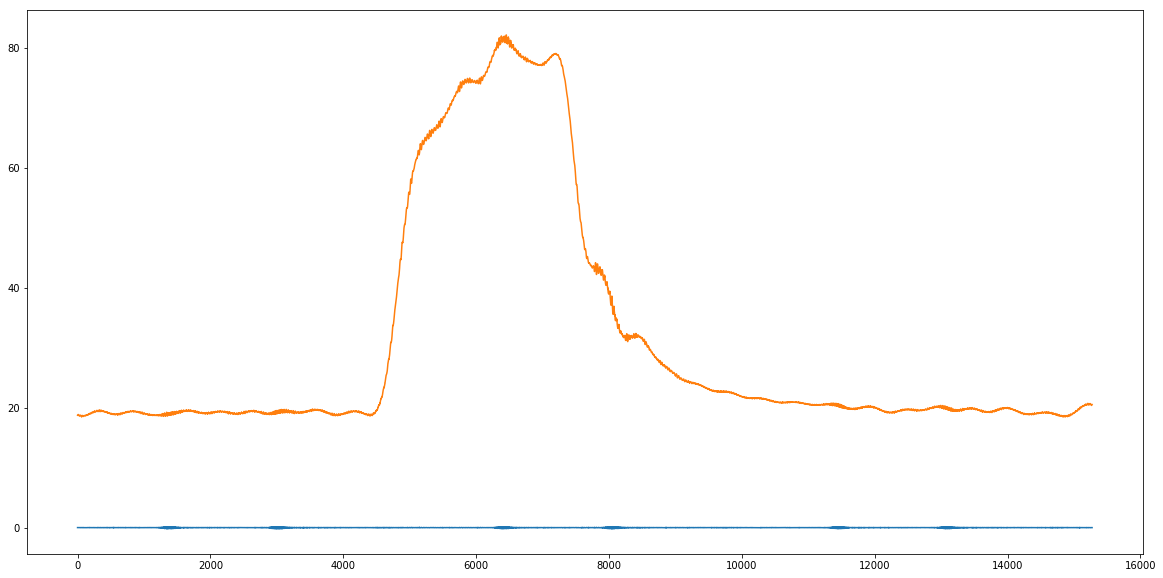

8044


In [41]:
# for_splitter = sg.symiirorder1(np.gradient(np.gradient(invertedO))[100:-100], 10,.91)
for_splitter = sg.wiener(np.gradient(np.gradient(invertedO))[100:-100])
corrected_splitter = np.argmin(for_splitter)
showMe(for_splitter, invertedO[100:-100])
print(corrected_splitter)

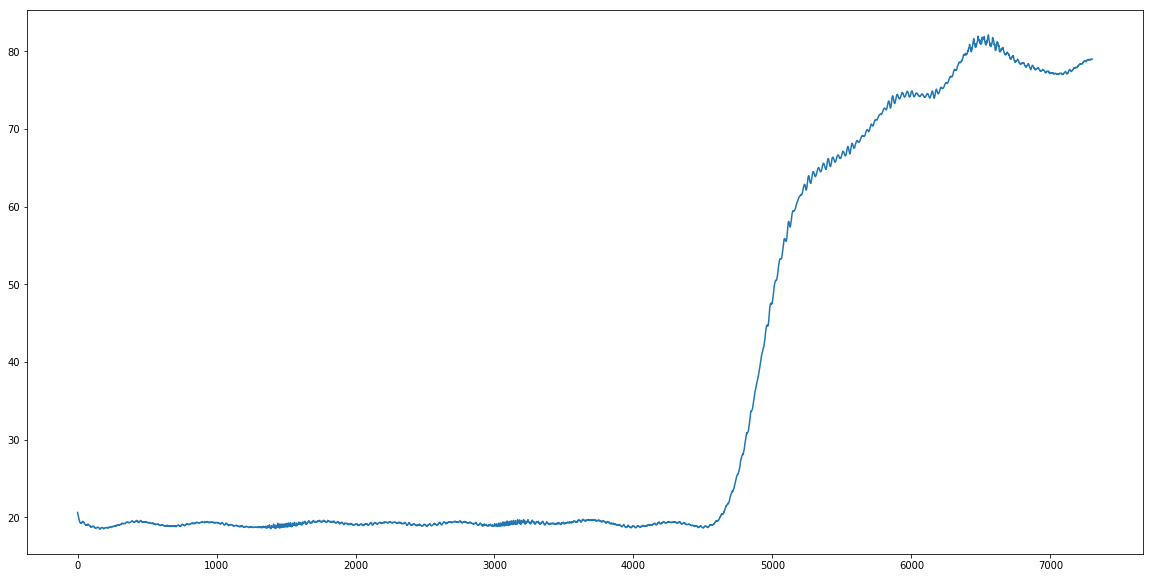

In [11]:
showMe(invertedO[:corrected_splitter])

In [12]:
np.savetxt("example_reg.txt", invertedO.real[:corrected_splitter], delimiter='\n')

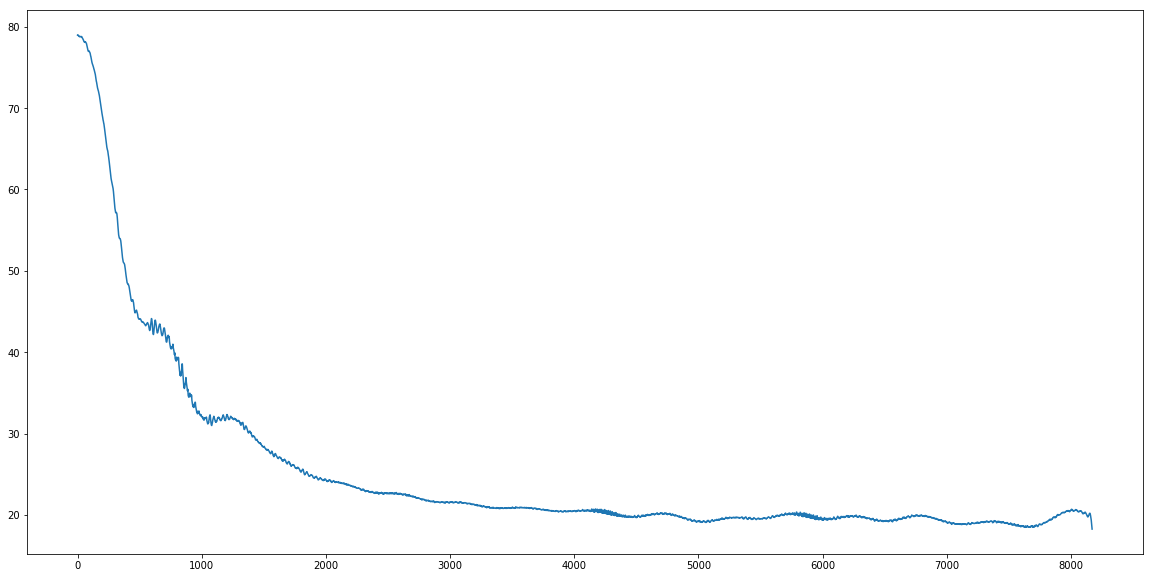

In [13]:
showMe(invertedO.real[corrected_splitter:])